In [160]:
# CSS formatting for the Notebook. Run to apply format
from IPython.core.display import HTML;      
HTML("""<link rel="stylesheet" href="./custom_two.css">""")

<div id=headerNotebook>
<h1 class=headtitle><b>Recommender Algorithm for Music</b><br/>2017 WIP Edition</h1>
<div class=date>18/03/2017</div>
<div class=authors><b>Authors</b>     Ole Andreas Hansen |
                            Alberto Ibarrondo Luis</div>
                            </div>

<div id=summary>
A recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.
</div>
<h2> Goals </h2>

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

<h2> Steps </h2>

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.

# Important note for grading
This notebook displays a series of questions, that we use to grade the work done. Since the following questions are rather basic, and do not change much from year to year, they only allow reaching the grade 10/20. Additional points can be gained by showing originality, depth, algorithmic design and implementations beyond that used in the notebook. Remember that this should become your own notebook: there is ample room for creativity!

# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [33]:
import os, sys, re, random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)

Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [34]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()
# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.

display(pd.DataFrame(userArtistDF.take(20), columns=(['userID', 'artistID', 'playCount'])))

,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314
5,1000002,1000013,8
6,1000002,1000014,42
7,1000002,1000017,69
8,1000002,1000024,329
9,1000002,1000025,1


#### Question 1.1: 
How many distinct users do we have in our data? 

In [4]:
uniqueUsers = userArtistDF.select('userID').distinct().count()
display(pd.DataFrame(userArtistDF.describe().take(5), columns=(['summary', 'userID', 'artistID', 'playcount'])))
print("Total n. of users: ", uniqueUsers)

# How many artist does a user listen to?
userArtistCount = userArtistDF.groupBy('userID').agg(countDistinct("artistID"))
pd.DataFrame(userArtistCount.take(5), columns=(['userID', 'nArtists']))

,summary,userID,artistID,playcount
0,count,24296858,24296858,24296858
1,mean,1947573.2653533637,1718704.0937568964,15.29576248089362
2,stddev,496000.5551818908,2539389.092428367,153.9153244698001
3,min,90,1,1
4,max,2443548,10794401,439771


Total n. of users:  148111


,userID,nArtists
0,1000061,113
1,1001372,230
2,1001409,318
3,1001530,707
4,1001731,832


#### Question 1.2
How many distinct artists do we have in our data ?

In [5]:

uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Question 1.3

One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than Integer.MAX_VALUE, or 2147483647, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.

What are the maximum and minimum values of column `userID` ?

HINT: Refer to section 4.3 of Laboratory 2.

In [6]:
print("Maximum userID: ", userArtistDF.select(max('userID')).collect()[0].asDict()['max(userID)'])
print("Minimum userID: ", userArtistDF.select(min('userID')).collect()[0].asDict()['min(userID)'])

userArtistDescr= userArtistDF.describe().toPandas()

Maximum userID:  2443548
Minimum userID:  90


#### Question 1.4
What is the maximum and minimum values of column `artistID` ?

In [7]:
print("Maximum artistID: ", userArtistDF.select(max('artistID')).collect()[0].asDict()['max(artistID)'])
print("Minimum artistID: ", userArtistDF.select(min('artistID')).collect()[0].asDict()['min(artistID)'])

Maximum artistID:  10794401
Minimum artistID:  1


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

In [68]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy('userID').sum('playCount')
userActivity = userActivity.withColumnRenamed('sum(playCount)', 'nplays')
#userActivity.take(5)
userCuriosity = userArtistDF.groupBy('userID').agg(countDistinct("artistID"))
userCuriosity = userCuriosity.withColumnRenamed('count(DISTINCT artistID)', 'nArtists')
userActCurios = userActivity.join(userCuriosity, 'userID')
userActCurios = userActCurios.orderBy(desc('nplays'))

pd.DataFrame(userActCurios.take(20), columns=(['userID', 'nPlays', 'nArtists']))

,userID,nPlays,nArtists
0,1059637,674412,359
1,2064012,548427,58
2,2069337,393515,259
3,2023977,285978,67
4,1046559,183972,1069
5,1052461,175822,241
6,1070932,168977,120
7,1031009,167273,760
8,2020513,165642,124
9,2062243,151504,746


Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

Mean play artist ratio for each user: 15.7303443875


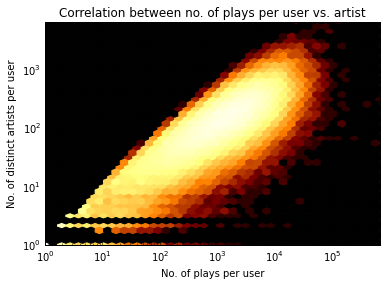

In [9]:
df_userActCurios = pd.DataFrame(data=userActCurios.select(['nPlays', 'nArtists']).collect(),\
                                columns=['nPlays', 'nArtists'])
x = np.array(df_userActCurios['nPlays'], dtype=np.float64)
y = np.array(df_userActCurios['nArtists'], dtype=np.float64)

userPlayArtistRatio = np.divide(x, y)
# On average each user will listen to the same artist x number of times
print("Mean play artist ratio for each user:", userPlayArtistRatio.mean())

plt.title('Correlation between no. of plays per user vs. artist')
plt.xlabel('No. of plays per user')
plt.ylabel('No. of distinct artists per user')
hb = plt.hexbin(x, y, bins='log', gridsize=40,  cmap='afmhot', xscale='log', yscale='log')

##### Insights on top figure
The general idea behind this graph is to see the relation between the number of plays and the number of distinct artist per user. There is a natural lower limit on the data which is a ratio of 1:1 (45 degrees diagonal on this plot ), since each song relates to at least one artist. 

As we can se there is some thight correlation between them with an average of 15.7 plays/artist per user: users listen on average 15 songs per artist. 

We can also extract information about the outliers by assigning a soft frontier to the ratio of plays/artist. We could roughly consider an outlier if his number of plays is a ~100 times more than his number of different artists, which in the figure represents the width in the x axis of the most populated region (the most yellow area).


### Question 2

#### Question 2.1
How many times each user has played a song? Show 5 samples of the result.

In [10]:
userActivity = userArtistDF.groupBy('userID').sum('playCount')
display(pd.DataFrame(userActivity.take(5), columns=['userID', 'playCount']))

,userID,playCount
0,1041783,8730
1,1042771,3
2,1043190,8
3,1043621,125
4,1043703,2609


#### Question 2.2
Plot CDF (or ECDF) of the number of play counts per User ID.

Explain and comment the figure you just created: 

* for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible.
* discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system.
* look at outliers and reason about their impact on your reccommender algorithm

[     0      1      2 ..., 148108 148109 148110]


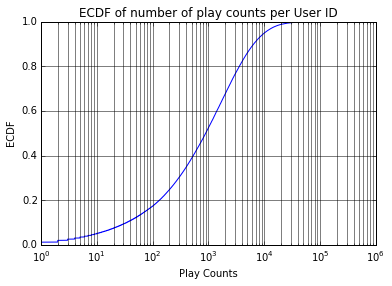

In [11]:
pdf = pd.DataFrame(data=userActivity.collect())
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.semilogx( Y, yvals )
plt.xlabel('Play Counts');
plt.ylabel('ECDF');
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

In [12]:
pdf[1].describe()
display(pdf[1].quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))
print("Top 99.99% values: ", Y[yvals >= 0.9999])
print("\nQuantile for average (2509): %.3f\n"%yvals[Y >= 2509][0])

0.01        1.0
0.10       34.0
0.25      204.0
0.50      892.0
0.75     2800.0
0.90     6484.0
0.99    21569.2
Name: 1, dtype: float64

Top 99.99% values:  [134032 135266 136293 143092 151504 165642 167273 168977 175822 183972
 285978 393515 548427 674412]

Quantile for average (2509): 0.726



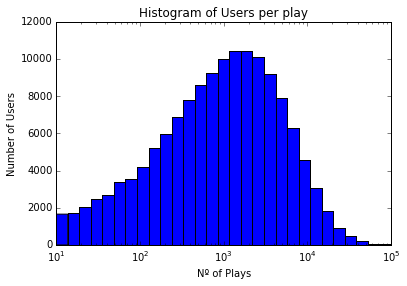

In [13]:
import matplotlib.mlab as mlab
plt.hist(Y, bins=np.logspace(1, 5, 30))
plt.gca().set_xscale("log")
plt.xlabel('Nº of Plays')
plt.ylabel('Number of Users')
plt.title(r'Histogram of Users per play')
plt.show()

#### Q2.2 - Answers

| Quantile | No. songs |
| ------ | ------ |
| 0.01 | 1.0 |
| 0.10 | 34.0 |
| 0.25 | 204.0 |
| 0.50 | 892.0 |
| 0.75 | 2800.0 |
| 0.90 | 6484.0 |
| 0.99 | 21569.2 |

As we can see from the quantile table most of the users have a relatively low number of plays, and in fact the average nº of plays (2509) is in the quantile 73%, showing that the data is skewed towards lower values. 

Results seem to be reasonable, having many users with small number of plays and few with big number (it's a typical distribution in modern networking platforms). Users with low count of plays may have to be separated from the rest and treated differently, since their recommendations will be error prone. 

It would also have been good to know the period of data collection in order to fully reason about the highest outliers. The user with the most plays has around 650k plays and if we assume that the average length of a song is 3 minutes this gives a minimum of 3.8 years of consecutive listening.

The ECDF follows a right skewed distribution (note that the figure above uses logarithmic axis), which is a typical sign for real networks (be it social or others) as stated in the following link and detailed in the [NetMod](http://mathinsight.org/degree_distribution) course in EURECOM.


#### Question 2.3

How many play counts for each artist? Plot CDF or ECDF of the result.

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?

In [14]:

# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy('artistID').sum('playCount')


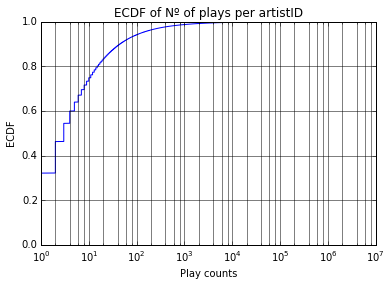

In [15]:
pdf = pd.DataFrame(data=artistPopularity.collect())
Y = np.sort(pdf[1])
# np.arange returns evenly spaced values inside given range. Why do we bother dividing Y by Y? To get a float?
yvals = np.arange(len(Y))/float(len(Y))

plt.semilogx(Y, yvals)
plt.xlabel('Play counts'); plt.ylabel('ECDF'); plt.grid(True,which="both",ls="-"); plt.title('ECDF of Nº of plays per artistID')
plt.show()

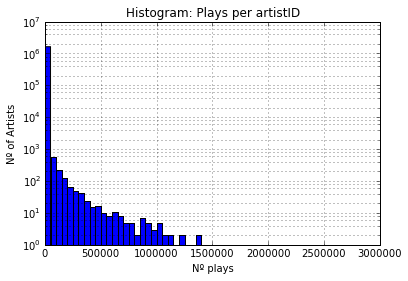

In [16]:
plt.hist(Y, log=True, bins=50)
plt.xlabel('Nº plays'); plt.ylabel('Nº of Artists'); plt.grid(True,which="both");
plt.title('Histogram: Plays per artistID')
plt.show()

##### Q2.3 - Answer
The figure shows that only a 20% of the artists have more than 200 hits, while the rest have less than 200, in a distribution similar to Pareto law. Repeating our skewness metric, we computed the quantile for the average (226 songs played per artist), obtaining a 96,6%. This, linked to the shape of the histogram (below, notice the log scale of y axis), shows that the distribution is **extremely right skewed**, a clear sign of a **power law distribution**:
https://en.wikipedia.org/wiki/Power_law

#### Question 2.4
Plot a bar chart to show top 5 artists In terms of absolute play counts.

Comment the figure you just obtained:

* are these reasonable results?
* is looking at top-5 artists enough to learn more about your data?
* do you see anything strange in the data?

In [17]:
# Analysis on the weight of the top artists
print("top10: %.3f %% \n"%(np.sum(Y[-10:])/np.sum(Y)*100))
print("top100: %.3f %%\n"%(np.sum(Y[-100:])/np.sum(Y)*100))
print("top1000: %.3f %%\n"%(np.sum(Y[-1000:])/np.sum(Y)*100))
print("top75k: %.3f %%\n"%(np.sum(Y[-75000:])/np.sum(Y)*100))

# Analyzing an anomaly detected in the data: there is a lot of artists with a single play:
print("Single play artists are up to: %.6f %%\n"%(yvals[Y==1][-1]*100))
print(len(yvals))
print(len(yvals[Y==1]))

top10: 4.356 % 

top100: 21.191 %

top1000: 57.107 %

top75k: 95.787 %

Single play artists are up to: 32.184671 %

1631028
524942


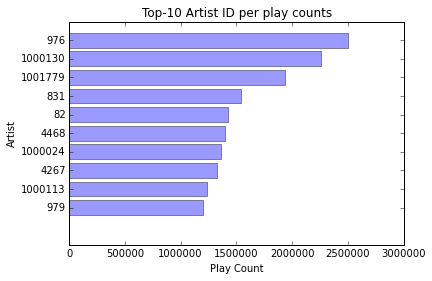

In [18]:
# Artist popularity format: artistID, sum(playCount). Want to sort on index 1 in DESC order
sortedArtist = sorted(artistPopularity.collect(), key = lambda x: -x[1])[:10]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos[::-1], artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

# It is reasonable that artists have such an high count, but the top five are all way above the 99% percentile@
# which is around 1000 plays. But when considering 1.6 million unique artists its reasonable. 

##### Q2.4 Answer
In order to assess the reasonability of the results, we compared our data to a similar platform: Spotify.
Literally stated by one of their analysts:
    "There are about about 2 million artists on Spotify, but the top 75k artists generate 95%+ of the streams"
    [Source](https://www.quora.com/What-are-the-total-number-of-artists-on-spotify).
Our top 10 artists cover 4,3% of the total amount of music plays, but since these can be considered outliers, this number is not representative enough. The top 75K users will do.
Running the Spotify calculation over LastFM data, we discovered that **95.8% of all music plays belong to the top 75k artists**, matching perfectly the numbers from Spotify, and thus we consider the results reasonable.


| Top | % of total |
| ------ | ------ |
| 10 | 4,3% |
| 100 | 21,2% |
| 1000 | 57,1% |
| 75000 | 95,8% |

Besides that, it seems like there is something strange in the opposite side of the data: we found that 32.2% of the artists have a single play (check the histogram above). This probably relates to typos when writing artist names that weren't sanitized, meaning that a single artist will still have some secondary copies inside the dataset.

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 10 samples.

HINT: If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

In [19]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache()
    
artistPD_DF = artistDF.toPandas()
display(artistPD_DF[1:11])

,artistID,name
1,6821360,Pang Nakarin
2,10113088,"Terfel, Bartoli- Mozart: Don"
3,10151459,The Flaming Sidebur
4,6826647,Bodenstandig 3000
5,10186265,Jota Quest e Ivete Sangalo
6,6828986,Toto_XX (1977
7,10236364,U.S Bombs -
8,1135000,artist formaly know as Mat
9,10299728,Kassierer - Musik für beide Ohren
10,10299744,"Rahzel, RZA"


#### Question 3.2
Find 20 artists whose name contains "Aerosmith". Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?

HINT: Function `locate(sub_string, string)` can be useful in this case.

In [76]:

# get artists whose name contains "Aerosmith"


display(pd.DataFrame(artistDF[locate("Aerosmith", artistDF.name) > 0].take(20), columns=(['artistID', 'name'])))


# show two examples
display(pd.DataFrame(artistDF[artistDF.artistID==1000010].take(20), columns=(['artistID', 'name'])))
display(pd.DataFrame(artistDF[artistDF.artistID==2082323].take(20), columns=(['artistID', 'name'])))

# Some are relevant to the artist since Aerosmith can have collaberated with for example run DMC.
# Other are less relevant

,artistID,name
0,10586006,Dusty Springfield/Aerosmith
1,6946007,Aerosmith/RunDMC
2,10475683,Aerosmith: Just Push Play
3,1083031,Aerosmith/ G n R
4,6872848,"Britney, Nsync, Nelly, Aerosmith,Mary J Blige."
5,10586963,Green Day - Oasis - Eminem - Aerosmith
6,10028830,The Aerosmith Antology2
7,10300357,Run-DMC + Aerosmith
8,2027746,Aerosmith by MusicInter.com
9,1140418,[rap]Run DMC and Aerosmith


,artistID,name
0,1000010,Aerosmith


,artistID,name
0,2082323,01 Aerosmith


##### Q3.2 answer

We see that ID 1000010 and 2082323 point to the same artist, Aerosmith. More formaly we say this because they share the same original name and the rest of the string does not match any other artist. Generalizing and looking at the 20 first rows we see that some artist containing Aerosmith is indeed a different artist or group. It is feasable that Aerosmith could have collaborated with Run DMC on an album. Some artist names imply that there is reasonable doubt about the artist being Aerosmith for example: `10033592 - Aerosmith?` where Aerosmith? could be any other artist.

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.

In [21]:
customSchemaArtistAlias = StructType([ \
    StructField('misspelledArtistID', LongType(), True ), \
    StructField('standardArtistID', LongType(), True)])


artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\\t') \
    .load(base + 'artist_alias.txt', schema = customSchemaArtistAlias)

display(pd.DataFrame(artistAliasDF.take(5), columns=(['misspelledArtistID', 'standardArtistID'])))

# We want the string value of misspelled artist mapped to their actual name.
artistNameAliasDF1 = pd.merge(
    pd.DataFrame(artistAliasDF.take(20), columns=(['artistID', 'standardArtistID'])),
    pd.DataFrame(artistDF.collect(), columns=(['artistID', 'Name'])),
    on='artistID',
    how='inner'
)
artistNameAliasDF2 = pd.merge(
    artistNameAliasDF1,
    pd.DataFrame(artistDF.collect(), columns=(['standardArtistID', 'Name'])),
    on='standardArtistID',
    how='inner'
)
display(artistNameAliasDF2[['Name_x', 'Name_y']])

,misspelledArtistID,standardArtistID
0,1092764,1000311
1,1095122,1000557
2,6708070,1007267
3,10088054,1042317
4,1195917,1042317


,Name_x,Name_y
0,"Winwood, Steve",Steve Winwood
1,Faithless Feat Dido,Faithless
2,Faithless featuring Dido,Faithless
3,Faithless feat. Dido,Faithless
4,i-Monster,I Monster
5,The Deluxx Folk Implosion,Deluxx Folk Implosion
6,Deluxe Folk Implosion,Deluxx Folk Implosion
7,Deluxxe Folk Implosion,Deluxx Folk Implosion
8,Ueto Aya,上戸彩
9,Tamaki Nami,玉置成実


##### Insights of table above
The table shows the actual textual representation of the misspelled artist mapped to their actual name. Here we can see how several compositions with the actual artist and others are simplified to the artist standard name ruling out collaborators. 

#### Question 3.4
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.

In [79]:

display(pd.DataFrame(artistAliasDF[artistAliasDF.misspelledArtistID==1000010].take(1), columns=(['misspelledArtistID', 'standardArtistID'])))
display(pd.DataFrame(artistAliasDF[artistAliasDF.misspelledArtistID==2082323].take(1), columns=(['misspelledArtistID', 'standardArtistID'])))


,misspelledArtistID,standardArtistID


,misspelledArtistID,standardArtistID
0,2082323,1000010


#### Q3.4 Answer
The table for ID 1000010 is empty which means that this is not a misspelled artist ID but the actual standard ID of Aerosmith. ID 2082323 is a misspelled ID which maps to the correct (standard) ID 1000010.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.

HINT: Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.

In [23]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0],\
                     row[1])).collectAsMap()

#### Question 4.2
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.

**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [81]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map( lambda x: replaceMispelledIDs(x) ), 
    userArtistDataSchema
)


#userArtistDF.show(50)
newUserArtistDF.show(5)

#newUserArtistPD = pd.DataFrame(newUserArtistDF.collect(), collumns=(['userID', 'artistID', 'playCount']))
#print(newUserArtistPD[newUserArtistPD.playCount==1].count())
t1 = time()

print('The script takes %f seconds' %(t1-t0))

newArtistPopularity = newUserArtistDF.groupBy('artistID').sum('playCount').cache()


# Testing with new
print('Searching the Duplicate artist ID = 10088054 in the original dataset:')
artistPopularity[artistPopularity.artistID == 10088054 ].show()
print('Searching the Standard artist ID 1042317 in the original dataset:')
artistPopularity[artistPopularity.artistID == 1042317 ].show()
print('Searching the Duplicate artist ID = 10088054 in the NEW dataset:')
newArtistPopularity[newArtistPopularity.artistID == 10088054 ].show()
print('Searching the Duplicate artist ID = 1042317 in the NEW dataset:')
newArtistPopularity[newArtistPopularity.artistID == 1042317 ].show()


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.114965 seconds
Searching the Duplicate artist ID = 10088054 in the original dataset:
+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
|10088054|             1|
+--------+--------------+

Searching the Standard artist ID 1042317 in the original dataset:
+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
| 1042317|           497|
+--------+--------------+

Searching the Duplicate artist ID = 10088054 in the NEW dataset:
+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
+--------+--------------+

Searching the Duplicate artist ID = 1042317 in the NEW dataset:
+--------+--------------+
|artistID|sum(playCoun

##### Q4.2 Answer
As we can see, one of the first hits in the [misspelledID, standardID] table has been updated: [10088054, 1042317] . The count of the standard ID 1042317 has been increased in 18 as a result of the correction of misspelled artistIDs

In [25]:
pandapanda = pd.DataFrame(newArtistPopularity.collect(), columns=(['artistID', 'playCount']))
ones = pandapanda[pandapanda.playCount==1]
print('Number of artists with only one play: ', len(ones))
print('Number of artists: ', len(pandapanda))
print('Percentage of artists with a single count:')
print(ones.artistID.count()/pandapanda.artistID.count()*100)

Number of artists with only one play:  504916
Number of artists:  1568126
Percentage of artists with a single count:
32.1986881156


np.arange returns evenly spaced values inside given range. Why do we bother dividing Y by Y? To get a float

As we can see, there is still a very high number of artistIDs with a single play.

#### Question 4.3
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task. 

We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. 

The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`

To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.


In [83]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0] , finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)

display(pd.DataFrame(newUserArtistDF.take(5), columns=(['userID', 'artistID', 'playCount'])))

t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()


,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314


The script takes 0.264250 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1

How many unique artists? Compare with the result when using old data.

In [27]:

uniqueArtists = newUserArtistDF.select('artistID').distinct().count()

print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1568126


##### Q5.1 Answer
The original number of artists was **1631028**, showing that the actual value of **1568126** improves the former value by renaming misspelled artistIDs in **62092** rows of data.

#### Question 5.2

Who are the top-10 artistis?
  * In terms of absolute play counts
  * In terms of "audience size", that is, how many users listened to one of their track at least once
  
Plot the results, and explain the figures you obtain.

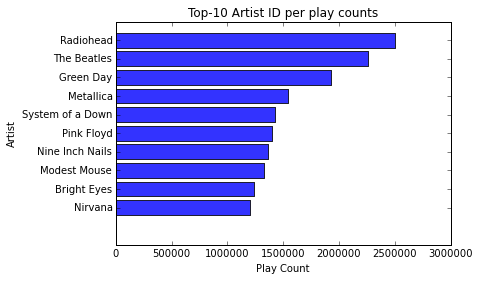

In [28]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)
top10ArtistNames = [ artistPD_DF[artistPD_DF.artistID==x]['name'].iloc[0] for x in pdf[0]]

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.8)
plt.yticks(y_pos[::-1], top10ArtistNames)
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()


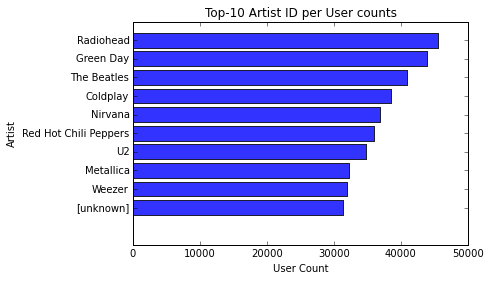

In [62]:
top10ArtistsUsersC = newUserArtistDF.groupBy('artistID').agg(countDistinct("userID"))\
    .withColumnRenamed('count(DISTINCT userID)', 'nUsers').orderBy('nUsers', ascending=0).take(10)
y_pos = range(len(top10ArtistsUsersC))
pdf = pd.DataFrame(data=top10ArtistsUsersC)
top10ArtistNames = [ artistPD_DF[artistPD_DF.artistID==x]['name'].iloc[0] for x in pdf[0]]

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.8)
plt.yticks(y_pos[::-1],top10ArtistNames)
plt.xlabel('User Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per User counts')
plt.show()

##### Q5.2 Insights
Funny enough, the 10th most popular artist based on user counts is [unknown], which must be the default for when a song was uploaded with no artist name.

#### Question 5.3

Who are the top-10 users?
  * In terms of absolute play counts
  * In terms of "curiosity", that is, how many different artists they listened to

Plot the results

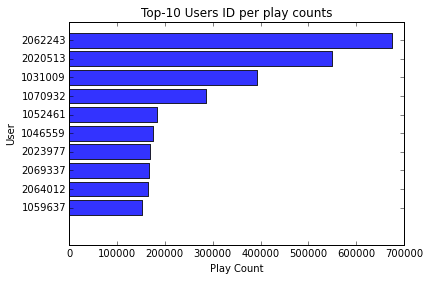

In [63]:

# calculate top 10 users interm of play counts
top10UsersByPlayCount = newUserArtistDF.groupBy('userID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.8)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

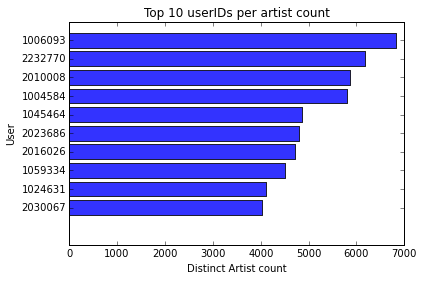

In [65]:

# calculate top 10 users interm of curiosity
top10UsersByCuriosity = newUserArtistDF.groupBy('userID').count().orderBy('count', ascending=0).take(10)

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.8)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Distinct Artist count')
plt.ylabel('User')
plt.title("Top 10 userIDs per artist count")
plt.show()


# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is converged. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we init the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row from $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


Now we have some valuable information about the data. It's the time to study how to build a statistical models.

### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:

Initialize $X$, $Y$

**while**(convergence is not true) **do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**

For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute 􏰀$\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute 􏰁$\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [35]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")


def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
    
                    # fileter out the special tuples
                    .filter( lambda x: x[0] > 0 )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

# print(artistAlias)

#### Question 6.2
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.

HINT: Using broadcast varible can help us increase the effiency.

In [36]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(disambiguate)
pd.DataFrame(userArtistDataRDD.take(5), columns=(['userId', 'artistID', 'playCount']))

,userId,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314


## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.

In [37]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [38]:
# OAH: From API rating has the format new Rating(user: int, product: int, rating: double) 
# so for our case Rating(userId, item, rating)
# allData does not include users that has not listened to an artist! (i think)
allData = userArtistDataRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(2).cache()


#### Question 7.2
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
* `training data` is the input data you decide to feed to the ALS algorithm
* `rank` is the number of laten features

We can also use some additional parameters to adjust the quality of the model. Currently, let's set 

- `rank=10`
- `iterations=5`
- `lambda_=0.01`
- `alpha=1.0` 

to build model.

In [40]:
# OAH: API reference https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering

t0 = time()
model = ALS.trainImplicit(ratings=allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 106.053008 secs


#### Question 7.3
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [41]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , 'lastfm_model.spark')

Deleted lastfm_model.spark


#### Question 7.4
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.

In [42]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 1.808513 secs


#### Question 7.5
Print the first 5 rows of user features in our model.

In [43]:
pd.set_option('max_colwidth',300)
display(pd.DataFrame(model.userFeatures().take(5), columns=['userID','Features']))

,userID,Features
0,120,"[-0.2567565441131592, 0.19304831326007843, 0.06923609972000122, -0.12228337675333023, 0.13595984876155853, -0.11351241171360016, -0.22060847282409668, -0.25669050216674805, 0.1135762482881546, -0.0003163852961733937]"
1,384,"[-1.9750630855560303, 4.34928035736084, -0.17394331097602844, -0.28999990224838257, 1.051230788230896, -0.23402169346809387, -1.0646283626556396, -1.7582918405532837, 0.988887369632721, -0.4771965742111206]"
2,828,"[0.03251377120614052, 0.07428038865327835, 0.02428736723959446, -0.01718446984887123, 0.049965228885412216, 0.031154602766036987, 0.05002003535628319, -0.08845587074756622, -0.025408733636140823, 0.019609441980719566]"
3,3048,"[-1.4768738746643066, 1.6182284355163574, 0.4502090513706207, 1.5616981983184814, -0.05334680899977684, -1.964806079864502, -2.454241991043091, -2.312035083770752, 0.3196096420288086, -0.020048268139362335]"
4,3216,"[-0.4844680428504944, 0.18508130311965942, 0.392788290977478, 0.3310469686985016, 0.059907812625169754, -0.10118768364191055, -0.47131118178367615, -0.5071861743927002, 0.009937555529177189, -0.30074870586395264]"


##### Q7.5 Insights
Features are characteristics of the model that are brought from the user related data. Similar features between users show that the tastes of both users are similar. Correlation between users is captured this way.The Rank measures the amount of data extracted from each user to construct the model. 

### Question 8
Show the top-5 artist names recommendated for user `2093760`.

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [44]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760, 5))

# construct set of recommendated artists
recArtist = set( x[1] for x in recommendations )

print(recArtist)

{1811, 1003249, 1300642, 1001819, 2814}


In [45]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
pd.DataFrame(artistByID.take(5), columns=(['artistID', 'artistName']))

,artistID,artistName
0,1134999,06Crazy Life
1,6821360,Pang Nakarin
2,10113088,"Terfel, Bartoli- Mozart: Don"
3,10151459,The Flaming Sidebur
4,6826647,Bodenstandig 3000


In [46]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda x: artistNames(x) == True).values().collect()

print(recList)
print('Number of recommendations: ', len(recList))

['50 Cent', 'Dr. Dre', 'Ludacris', '2Pac', 'The Game']
Number of recommendations:  5


#### IMPORTANT NOTE

At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.

In [47]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:

- rank=10
- iterations=5
- lambda_=0.01
- alpha=1.0

In [48]:

trainData, cvData = allData.randomSplit(weights=[0.9, 0.1])
trainData.cache()
cvData.cache()

PythonRDD[423] at RDD at PythonRDD.scala:48

In [49]:
t0 = time()
model = ALS.trainImplicit( ratings=trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 135.007580 secs


#### Area under the ROC curve: a function to compute it

In [50]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [51]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

In [52]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9672468341002487
finish in 86.524243 seconds


##### Q9.2 Insights
"A ROC curve plots recall (true positive rate) against fallout (false positive rate) for increasing recommendation set size." [Schröder, Thiele, Lehner 2011](http://wiki.epfl.ch/edicpublic/documents/Candidacy%20exam/Evaluation.pdf)

The top items our algorithm recommends for a user are the Positive items, and the unrecommended items are Negative.
 - **True Positive** items are therefore the items that we showed in our Top-N list that match what the user preferred in our cv data.
 - **False Positive** are the items in our Top-N list that don't match preferred items in cv data.
 - **True Negative** items are those we didn't include in our Top-N recommendations and are items the user didn't have in his preferred items in cv data.
 - **False Negative** are items we didn't include in our Top-N recommendations but do match what the user preferred in her held-out testing set.

#### Question 9.3
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective. 

Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.

In [53]:

bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda r1, r2: r1+r2).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))


In [54]:

auc = calculateAUC(cvData, bListenCount, predictMostListened)
print('Accuracy (Area under the Curve): %.2f %%'%(auc*100))

Accuracy (Area under the Curve): 93.74 %


## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.

In [57]:

evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( ratings=trainData, rank=rank, lambda_=lambda_, alpha=alpha, iterations=5 )
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)




Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [60]:
evaluations.sort(key=lambda x:x[1])
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0   (50, 0.0001, 1.0)  0.953464
1      (50, 1.0, 1.0)  0.967031
2   (10, 0.0001, 1.0)  0.967561
3      (10, 1.0, 1.0)  0.969395
4  (50, 0.0001, 40.0)  0.975270
5     (50, 1.0, 40.0)  0.976213
6  (10, 0.0001, 40.0)  0.976601
7     (10, 1.0, 40.0)  0.977040


PythonRDD[423] at RDD at PythonRDD.scala:48

#### Question 10.2 

Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user 2093760.

In [61]:
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 5)

recommendedProductIDs = set(x.product for x in recommendations)

recList = artistByID.filter(lambda x: (x[0] in recommendedProductIDs)).values().collect()
print(recList)

unpersist(model)

['[unknown]', 'Eminem', 'The Killers', 'U2', 'Green Day']


##### Q 10.2 Insights
We see that **[unknown] is the first reccomendation**. This is probably due to the huge variety in songs that are registered under the artistID of [unknown], which you could expect to be much higher than those of any real artist. If we also take into account that [unknown] is the 10th artist with more distinct users, we can expect a high number of colourful and diverse songs attached to that default name. 

# 4. Confidence Levels in collaborative filtering
Inplicit feedback is inherently noisy, meaning that we are not sure of several things: a single account could be used by somone else than the owner of the account to listen to more diverse music. Also, a single user does not necessary like all the songs he listens to, or at least not in the same level.

Our final goal is to obtain a metric of the degree of confidence from implicit data that we have already.

In order to do that, we are gonna be using a library that approaches this problem: [Fast Python Collaborative Filtering for Implicit Datasets](https://github.com/benfred/implicit)

## 4.1 Implementation

### 4.1.1 Import Packages 

In [84]:
# Import packets for the confidence levels implementation
import annoy
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

### 4.1.2 Prepare Dataset
We are gonna cut a portion of allData to use, since we are running the optimization in the VM machine and not in the spark cluster. 

In [97]:

unusedData, ourData = allData.randomSplit(weights=[0.99, 0.01])
ourDataPD = pd.DataFrame(ourData.take(1000000), columns=(['userId', 'artistID', 'playCount']))


In [104]:
ourDataPD['userId'] = ourDataPD['userId'].astype("category")
ourDataPD['artistID'] = ourDataPD['artistID'].astype("category")
plays = coo_matrix((ourDataPD['playCount'].astype(float),(ourDataPD['artistID'].cat.codes.copy(),\
                                                 ourDataPD['userId'].cat.codes.copy())))

### 4.1.3 Class ALS for training and reccomendation

In [105]:
# A version of the AlternatingLeastSquares model that uses an annoy index to calculate similar items.
# This should lead to massive when called repeatedly
class AnnoyAlternatingLeastSquares(AlternatingLeastSquares):
    def fit(self, Ciu):
        # train the model
        super(AnnoyAlternatingLeastSquares, self).fit(Ciu)

        # build up an index with all the item_factors
        index = annoy.AnnoyIndex(self.item_factors.shape[1], 'angular')
        for i, row in enumerate(self.item_factors):
            index.add_item(i, row)
        index.build(self.factors / 2)
        self.index = index

    def similar_items(self, artistid, N=10):
        neighbours = self.index.get_nns_by_item(artistid, N)
        return sorted(((other, 1 - self.index.get_distance(artistid, other))
                      for other in neighbours), key=lambda x: -x[1])

In [138]:
def calculate_similar_artists(df, plays, model_name="als", factors=50, reg=0.01, iterations=15, exact=False, trees=20, 
                              use_native=True, dtype=np.float64, cg=False):

    # generate a recommender model based off the input params
    if model_name == "als":
        model = AlternatingLeastSquares(factors=factors, regularization=reg,
                                                 use_native=use_native, use_cg=cg,
                                                 dtype=dtype)

        # Weight the model using bm25weight, obtaining the Confidence levels
        plays = bm25_weight(plays, K1=100, B=0.8)

    ####### OTHER MODELS SHOULD BE HERE! (Section 4.2)    
        
    # train the model
    model.fit(plays)    
    
    # write out similar artists by popularity
    user_count = df.groupby('artistID').size()
    artists = dict(enumerate(df['artistID'].cat.categories))
    to_generate = sorted(list(artists), key=lambda x: -user_count[x])
    
    with open('confidentArtists.txt', "w") as o:
        for artistid in to_generate:
            artist = artists[artistid]
            for other, score in model.similar_items(artistid, 11):
                o.write("%s\t%s\t%s\n" % (artist, artists[other], score))

In [ ]:
calculate_similar_artists(df=ourDataPD, plays=plays)

In [159]:
artist1 = artistDF[artistDF.artistID==1035076].collect()[0].asDict()['name']
artist2 = artistDF[artistDF.artistID==1009175].collect()[0].asDict()['name']
artist3 = artistDF[artistDF.artistID==6797697].collect()[0].asDict()['name']

print('Example of similar artists (top of the output file):')
print('Artists similar to Radiohead (979) would be: ', artist1, ', ', artist2, ', ', artist3 )

Example of similar artists (top of the output file):
Artists similar to Radiohead (979) would be:  Cabala ,  T-Rex ,  Adrienne Young


### 4.1.4 Insights on this section
We tried to implement confidence levels on a subset of the ddataset, but several problems arose and we could not meet the expectations. What we could obtain is a scoring between different artists based on similarity relations. This could be used to make as many reccomendations as possible unsubscribed new user (with no previous information about him). Further use of this library would allow us to recommend artists to a user with the following function:

`recommendations = model.recommend(userid, item_user_data.T)`

## 4.2 Other possible Models
Even further, we could implement different recommender algorithms by tweaking the previous code.

In [ ]:
# We could include this inside the previous code
    elif model_name == "tfidf":
    model = AlternatingLeastSquares(factors=factors, regularization=regularization,
                                        use_native=use_native, use_cg=cg,
                                        dtype=dtype)
    elif model_name == "tfidf":
    model = TFIDFRecommender()

    elif model_name == "cosine":
        model = CosineRecommender()

    elif model_name == "bm25":
        model = BM25Recommender(K1=100, B=0.5)

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)